In [2]:
import numpy as np
import pandas as pd

from keras import regularizers, activations
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime

from matplotlib import pyplot as plt
%matplotlib inline

import librosa
import librosa.display
from keras.models import load_model

In [3]:
import os

# Set this to the relative or absolute path of your local US8K directory
local_us8k_path = "./"  # or r"C:\Users\YourName\path\to\US8K"

if os.path.exists(local_us8k_path):
    os.chdir(local_us8k_path)
    print(f"Changed working directory to: {os.getcwd()}")
else:
    raise FileNotFoundError(f"The directory '{local_us8k_path}' does not exist.")


Changed working directory to: d:\UrbanSound8K


---

## 0. Load the preprocessed data <a name="zero-bullet"></a>

In [4]:
us8k_df = pd.read_pickle("us8k_df.pkl")

In [5]:
us8k_df.head()

,melspectrogram,label,fold
0,"[[-68.9679, -74.4974, -65.13365, -65.75227, -6...",3,5
1,"[[-17.170397, -3.6112595, -12.501213, -13.6347...",2,5
2,"[[-26.222954, -14.915925, -6.091381, -12.99589...",2,5
3,"[[-17.566498, -12.813037, -12.300038, -11.4390...",2,5
4,"[[-14.985382, 9.536743e-07, -11.1152115, -10.5...",2,5


---

## 1. Data augmentation <a name="first-bullet"></a>

In [6]:
def init_data_aug():
    train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode = 'constant',
        cval=-80.0,
        width_shift_range=0.1,
        height_shift_range=0.0)

    val_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode = 'constant',
        cval=-80.0)

    return train_datagen, val_datagen

---

## 2. CNN model  <a name="second-bullet"></a>


In [7]:
def init_model():
    model1 = Sequential()

    #layer-1
    model1.add(Conv2D(filters=24, kernel_size=5, input_shape=(128, 128, 1),
                      kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(3,3), strides=3))
    model1.add(Activation(activations.relu))

    #layer-2
    model1.add(Conv2D(filters=36, kernel_size=4, padding='valid', kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model1.add(Activation(activations.relu))

    #layer-3
    model1.add(Conv2D(filters=48, kernel_size=3, padding='valid'))
    model1.add(Activation(activations.relu))

    model1.add(GlobalAveragePooling2D())

    #layer-4 (1st dense layer)
    model1.add(Dense(60, activation='relu'))
    model1.add(Dropout(0.5))

    #layer-5 (2nd dense layer)
    model1.add(Dense(10, activation='softmax'))


    # compile
    model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model1

In [8]:
model = init_model()
model.summary()

C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 24)   │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 41, 41, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 41, 41, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 38, 38, 36)     │        13,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 19, 19, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 48)     │        15,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 17, 17, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │         2,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,634 (131.38 KB)

 Trainable params: 33,634 (131.38 KB)

 Non-trainable params: 0 (0.00 B)

---

## 3. Helper functions  <a name="third-bullet"></a>

In [9]:
from sklearn.model_selection import train_test_split as sk_train_test_split

def train_test_split(fold_k, data, X_dim=(128, 128, 1)):
    if fold_k == 0:
        # Random 80-20 split
        X = np.stack(data.melspectrogram.to_numpy())
        y = data.label.to_numpy()

        X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    else:
        X_train = np.stack(data[data.fold != fold_k].melspectrogram.to_numpy())
        X_test = np.stack(data[data.fold == fold_k].melspectrogram.to_numpy())

        y_train = data[data.fold != fold_k].label.to_numpy()
        y_test = data[data.fold == fold_k].label.to_numpy()

    XX_train = X_train.reshape(X_train.shape[0], *X_dim)
    XX_test = X_test.reshape(X_test.shape[0], *X_dim)

    yy_train = to_categorical(y_train)
    yy_test = to_categorical(y_test)

    return XX_train, XX_test, yy_train, yy_test

In [10]:
def process_fold(fold_k, data, epochs=100, num_batch_size=32):
    X_train, X_test, y_train, y_test = train_test_split(fold_k, data)
    train_datagen, val_datagen = init_data_aug()
    train_datagen.fit(X_train)
    val_datagen.fit(X_train)

    model = init_model()

    # Save best model (change monitor to 'val_loss' if needed)
    checkpoint_cb = ModelCheckpoint(
        f"saved_models/best_model_fold{fold_k}.keras",
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    print("Pre-training accuracy: %.4f%%\n" % (100 * model.evaluate(val_datagen.flow(X_test, y_test, batch_size=num_batch_size), verbose=0)[1]))

    start = datetime.now()
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=num_batch_size),
        steps_per_epoch=int(len(X_train) / num_batch_size),
        epochs=epochs,
        validation_data=val_datagen.flow(X_test, y_test, batch_size=num_batch_size),
        callbacks=[checkpoint_cb]
    )
    end = datetime.now()
    print("Training completed in time: ", end - start, '\n')

    return history


In [11]:
def show_results(tot_history):
    """Show accuracy and loss graphs for train and test sets, with stats."""

    for i, history in enumerate(tot_history):
        print('\n({})'.format(i + 1))

        plt.figure(figsize=(15, 5))

        # Accuracy plot
        plt.subplot(121)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.grid(linestyle='--')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        # Loss plot
        plt.subplot(122)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.grid(linestyle='--')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.show()

        print(f"\tFinal train accuracy: {history.history['accuracy'][-1] * 100:.4f} %")
        print(f"\tMax train accuracy: {np.max(history.history['accuracy']) * 100:.4f} %")
        print(f"\tFinal validation accuracy: {history.history['val_accuracy'][-1] * 100:.4f} %")
        print(f"\tMax validation accuracy: {np.max(history.history['val_accuracy']) * 100:.4f} %")
        print(f"\tFinal training loss: {history.history['loss'][-1]:.5f}")
        print(f"\tMin training loss: {np.min(history.history['loss']):.5f}")
        print(f"\tFinal validation loss: {history.history['val_loss'][-1]:.5f}")
        print(f"\tMin validation loss: {np.min(history.history['val_loss']):.5f}")


---

## 4. 10-Fold Cross Validation  <a name="fourth-bullet"></a>

### fold-1 <a name="fold-1"></a>

In [11]:
FOLD_K = 1
REPEAT = 1

history1 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history1.append(history)

--------------------------------------------------------------------------------

(1)



C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Pre-training accuracy: 4.1237%

Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1828 - loss: 2.1898
Epoch 1: val_loss improved from inf to 1.80646, saving model to saved_models/best_model_fold1.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - accuracy: 0.1830 - loss: 2.1894 - val_accuracy: 0.3047 - val_loss: 1.8065
Epoch 2/100
  1/245 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.2188 - loss: 2.0007

C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.80646
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2188 - loss: 2.0007 - val_accuracy: 0.2944 - val_loss: 1.8109
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2987 - loss: 1.9026
Epoch 3: val_loss improved from 1.80646 to 1.66418, saving model to saved_models/best_model_fold1.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.2987 - loss: 1.9024 - val_accuracy: 0.3940 - val_loss: 1.6642
Epoch 4/100
  1/245 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.3438 - loss: 1.7521
Epoch 4: val_loss improved from 1.66418 to 1.65745, saving model to saved_models/best_model_fold1.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3438 - loss: 1.7521 - val_accuracy: 0.4112 - val_loss: 1.6574
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3732 - loss: 1.7000
Epoch 5: val_loss improved from 1.65745 to 1.47008, saving model to saved_models/best_model_fold1.keras
245/245 ━━━━━━━━━━━━


(1)


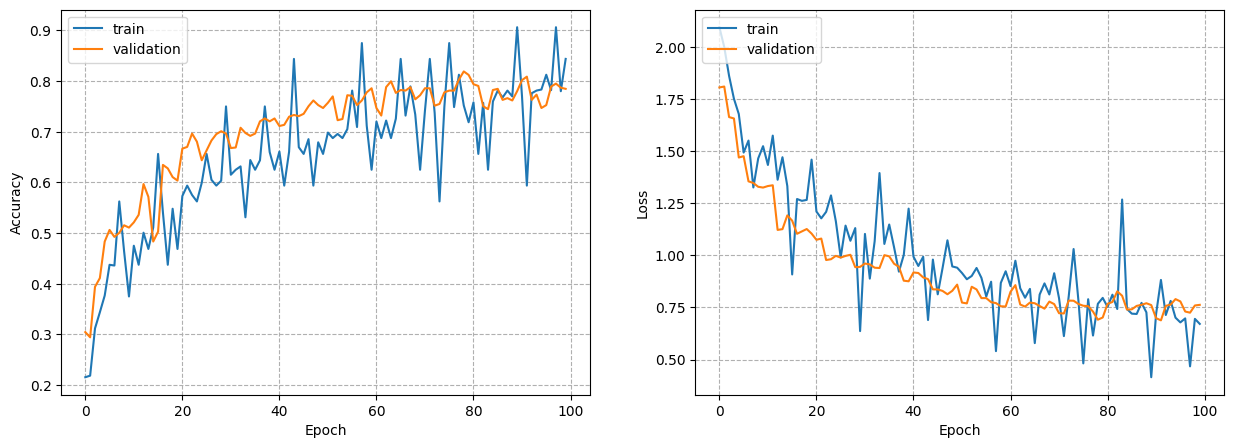

	Final train accuracy: 84.3750 %
	Max train accuracy: 90.6250 %
	Final validation accuracy: 78.4651 %
	Max validation accuracy: 81.9015 %
	Final training loss: 0.67101
	Min training loss: 0.41494
	Final validation loss: 0.76248
	Min validation loss: 0.68813


In [12]:
show_results(history1)

### fold-2 <a name="fold-2"></a>

In [13]:
FOLD_K = 2
REPEAT = 1

history2 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history2.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 13.9640%

Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1758 - loss: 2.2000
Epoch 1: val_loss improved from inf to 1.87741, saving model to saved_models/best_model_fold2.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - accuracy: 0.1759 - loss: 2.1995 - val_accuracy: 0.2387 - val_loss: 1.8774
Epoch 2/100
  1/245 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.3125 - loss: 1.8995
Epoch 2: val_loss did not improve from 1.87741
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3125 - loss: 1.8995 - val_accuracy: 0.2331 - val_loss: 1.8866
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2680 - loss: 1.9202
Epoch 3: val_loss improved from 1.87741 to 1.72748, saving model to saved_models/best_model_fold2.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.2680 - loss: 1.9201 - val_accuracy: 0.3209 - val_loss: 1.7275
Epoch 


(1)


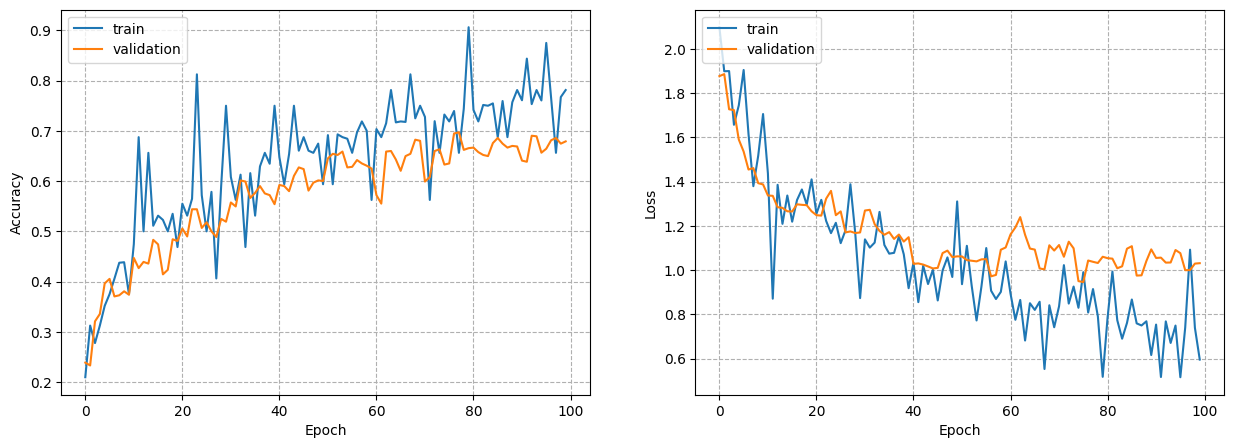

	Final train accuracy: 78.1250 %
	Max train accuracy: 90.6250 %
	Final validation accuracy: 67.9054 %
	Max validation accuracy: 69.7072 %
	Final training loss: 0.59539
	Min training loss: 0.51554
	Final validation loss: 1.03134
	Min validation loss: 0.94580


In [14]:
show_results(history2)

### fold-3 <a name="fold-3"></a>

In [15]:
FOLD_K = 3
REPEAT = 1

history3 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history3.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 16.3243%

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1957 - loss: 2.1701
Epoch 1: val_loss improved from inf to 1.95227, saving model to saved_models/best_model_fold3.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.1958 - loss: 2.1698 - val_accuracy: 0.2638 - val_loss: 1.9523
Epoch 2/100
  1/243 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.3438 - loss: 1.9019
Epoch 2: val_loss did not improve from 1.95227
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3438 - loss: 1.9019 - val_accuracy: 0.2454 - val_loss: 1.9526
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2838 - loss: 1.9147
Epoch 3: val_loss improved from 1.95227 to 1.84082, saving model to saved_models/best_model_fold3.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - accuracy: 0.2838 - loss: 1.9146 - val_accuracy: 0.3589 - val_loss: 1.8408
Epoch


(1)


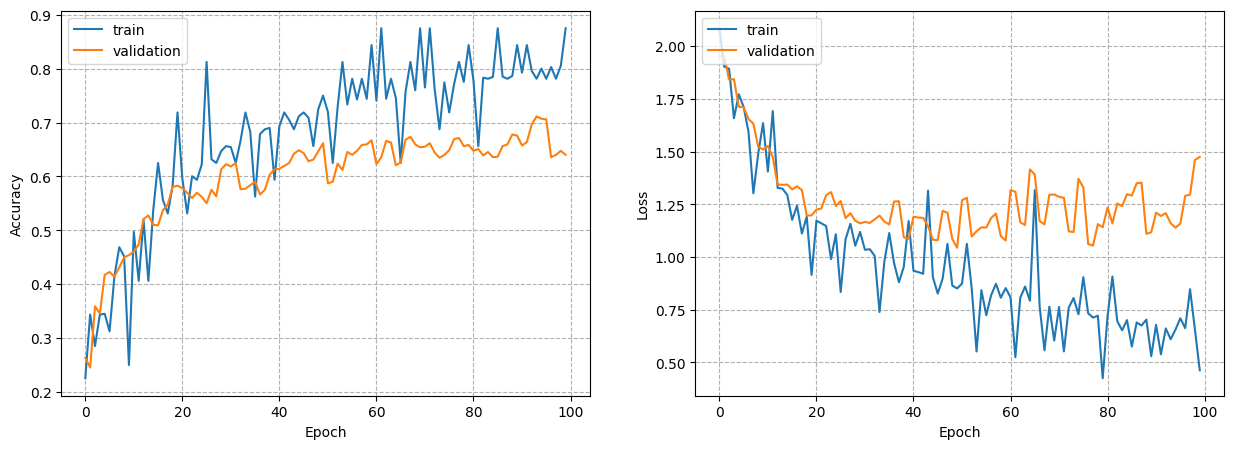

	Final train accuracy: 87.5000 %
	Max train accuracy: 87.5000 %
	Final validation accuracy: 64.0000 %
	Max validation accuracy: 71.1351 %
	Final training loss: 0.46301
	Min training loss: 0.42533
	Final validation loss: 1.47469
	Min validation loss: 1.04358


In [16]:
show_results(history3)

### fold-4 <a name="fold-4"></a>

In [17]:
FOLD_K = 4
REPEAT = 1

history4 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history4.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 12.1212%

Epoch 1/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.1843 - loss: 2.1900
Epoch 1: val_loss improved from inf to 2.00109, saving model to saved_models/best_model_fold4.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.1844 - loss: 2.1895 - val_accuracy: 0.2394 - val_loss: 2.0011
Epoch 2/100
  1/241 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.1250 - loss: 2.1245
Epoch 2: val_loss improved from 2.00109 to 1.99955, saving model to saved_models/best_model_fold4.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.1250 - loss: 2.1245 - val_accuracy: 0.2212 - val_loss: 1.9996
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2777 - loss: 1.9127
Epoch 3: val_loss improved from 1.99955 to 1.85734, saving model to saved_models/best_model_fold4.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.2777 - los


(1)


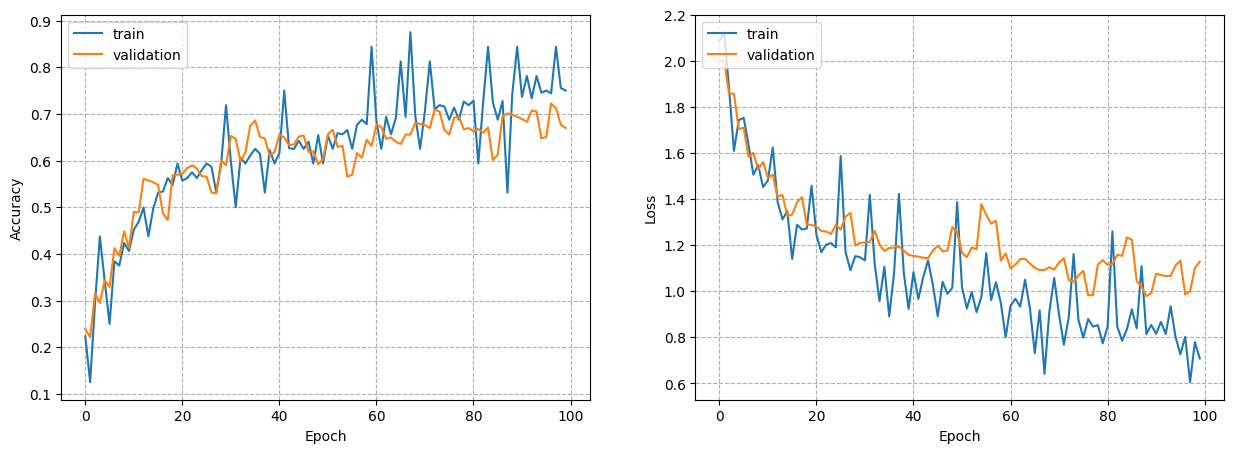

	Final train accuracy: 75.0000 %
	Max train accuracy: 87.5000 %
	Final validation accuracy: 66.9697 %
	Max validation accuracy: 72.2222 %
	Final training loss: 0.70791
	Min training loss: 0.60486
	Final validation loss: 1.12812
	Min validation loss: 0.97826


In [18]:
show_results(history4)

### fold-5 <a name="fold-5"></a>

In [19]:
FOLD_K = 5
REPEAT = 1

history5 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history5.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 8.3333%

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1808 - loss: 2.2002
Epoch 1: val_loss improved from inf to 1.98351, saving model to saved_models/best_model_fold5.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 144ms/step - accuracy: 0.1810 - loss: 2.1998 - val_accuracy: 0.2115 - val_loss: 1.9835
Epoch 2/100
  1/243 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.2812 - loss: 1.9240
Epoch 2: val_loss did not improve from 1.98351
243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2812 - loss: 1.9240 - val_accuracy: 0.2115 - val_loss: 1.9885
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2877 - loss: 1.8932
Epoch 3: val_loss improved from 1.98351 to 1.74093, saving model to saved_models/best_model_fold5.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - accuracy: 0.2878 - loss: 1.8929 - val_accuracy: 0.4135 - val_loss: 1.7409
Epoch 


(1)


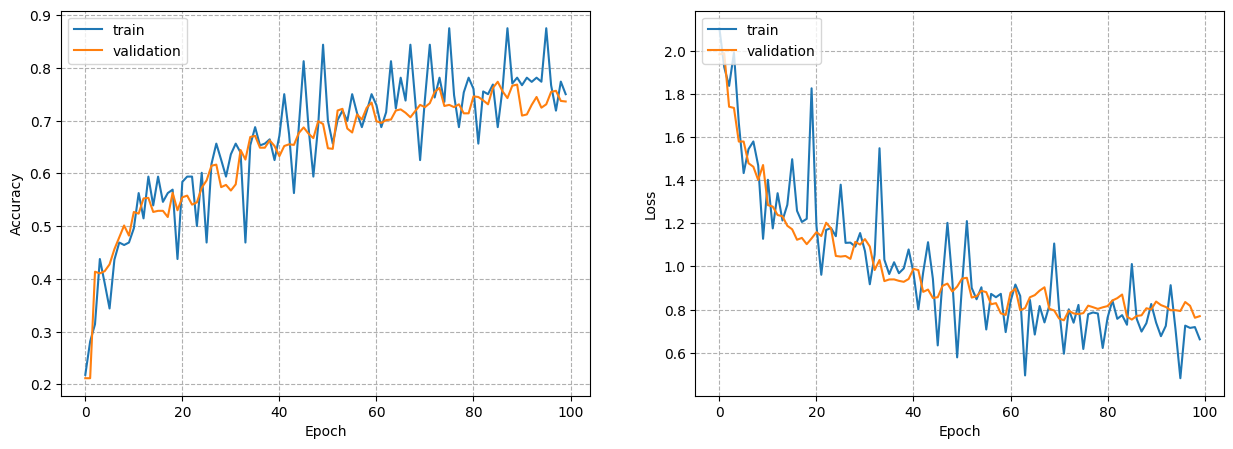

	Final train accuracy: 75.0000 %
	Max train accuracy: 87.5000 %
	Final validation accuracy: 73.6111 %
	Max validation accuracy: 77.3504 %
	Final training loss: 0.66222
	Min training loss: 0.48171
	Final validation loss: 0.76956
	Min validation loss: 0.75041


In [20]:
show_results(history5)

### fold-6 <a name="fold-6"></a>

In [21]:
FOLD_K = 6
REPEAT = 1

history6 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history6.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 5.5893%

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1744 - loss: 2.1849
Epoch 1: val_loss improved from inf to 1.88648, saving model to saved_models/best_model_fold6.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - accuracy: 0.1746 - loss: 2.1846 - val_accuracy: 0.2369 - val_loss: 1.8865
Epoch 2/100
  1/247 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.3438 - loss: 1.9554
Epoch 2: val_loss improved from 1.88648 to 1.88610, saving model to saved_models/best_model_fold6.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.3438 - loss: 1.9554 - val_accuracy: 0.2394 - val_loss: 1.8861
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2726 - loss: 1.9006
Epoch 3: val_loss improved from 1.88610 to 1.68079, saving model to saved_models/best_model_fold6.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.2726 - loss


(1)


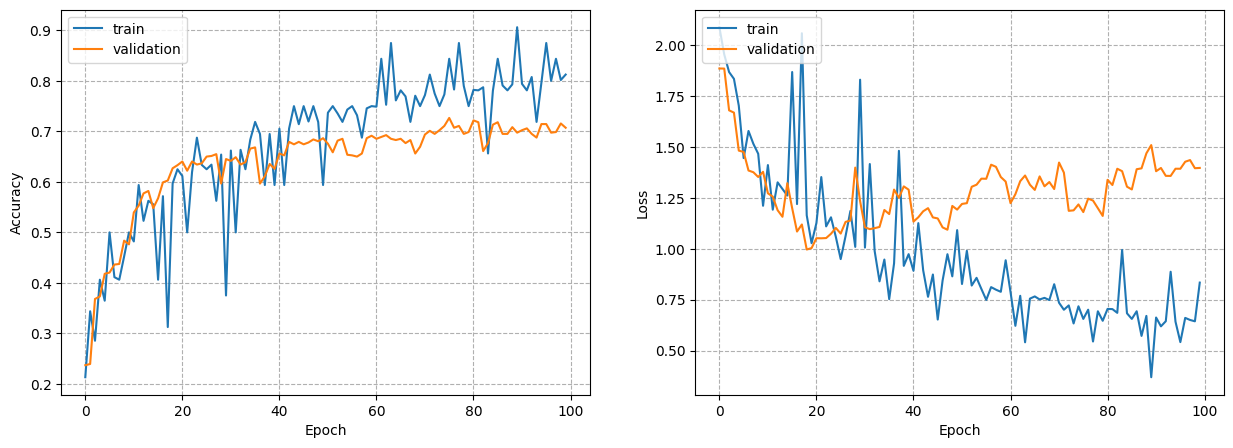

	Final train accuracy: 81.2500 %
	Max train accuracy: 90.6250 %
	Final validation accuracy: 70.7169 %
	Max validation accuracy: 72.6610 %
	Final training loss: 0.83393
	Min training loss: 0.36865
	Final validation loss: 1.39764
	Min validation loss: 0.99652


In [22]:
show_results(history6)

### fold-7 <a name="fold-7"></a>

In [23]:
FOLD_K = 7
REPEAT = 1

history7 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history7.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 4.8926%

Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1892 - loss: 2.1711
Epoch 1: val_loss improved from inf to 1.99356, saving model to saved_models/best_model_fold7.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.1893 - loss: 2.1708 - val_accuracy: 0.2220 - val_loss: 1.9936
Epoch 2/100
  1/246 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.2812 - loss: 2.0012
Epoch 2: val_loss improved from 1.99356 to 1.97174, saving model to saved_models/best_model_fold7.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.2812 - loss: 2.0012 - val_accuracy: 0.2315 - val_loss: 1.9717
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2641 - loss: 1.9225
Epoch 3: val_loss improved from 1.97174 to 1.82826, saving model to saved_models/best_model_fold7.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.2641 - loss:


(1)


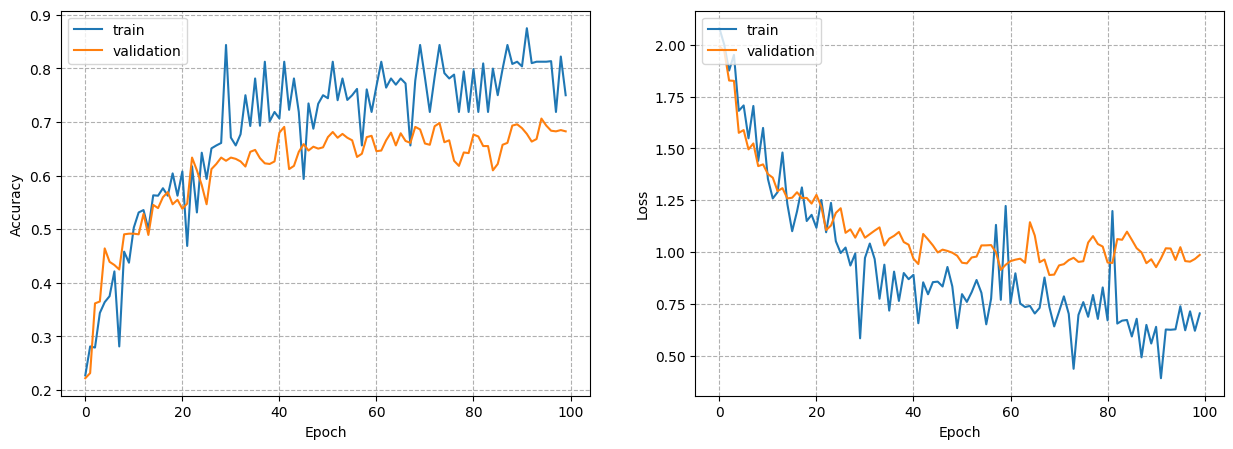

	Final train accuracy: 75.0000 %
	Max train accuracy: 87.5000 %
	Final validation accuracy: 68.2578 %
	Max validation accuracy: 70.6444 %
	Final training loss: 0.70358
	Min training loss: 0.39053
	Final validation loss: 0.98612
	Min validation loss: 0.88899


In [24]:
show_results(history7)

### fold-8 <a name="fold-8"></a>

In [25]:
FOLD_K = 8
REPEAT = 1

history8 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history8.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 9.6774%

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1967 - loss: 2.1701
Epoch 1: val_loss improved from inf to 1.88853, saving model to saved_models/best_model_fold8.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.1967 - loss: 2.1698 - val_accuracy: 0.2457 - val_loss: 1.8885
Epoch 2/100
  1/247 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.2500 - loss: 1.8227
Epoch 2: val_loss improved from 1.88853 to 1.88763, saving model to saved_models/best_model_fold8.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.2500 - loss: 1.8227 - val_accuracy: 0.2444 - val_loss: 1.8876
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2356 - loss: 1.9799
Epoch 3: val_loss improved from 1.88763 to 1.75444, saving model to saved_models/best_model_fold8.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.2357 - loss: 


(1)


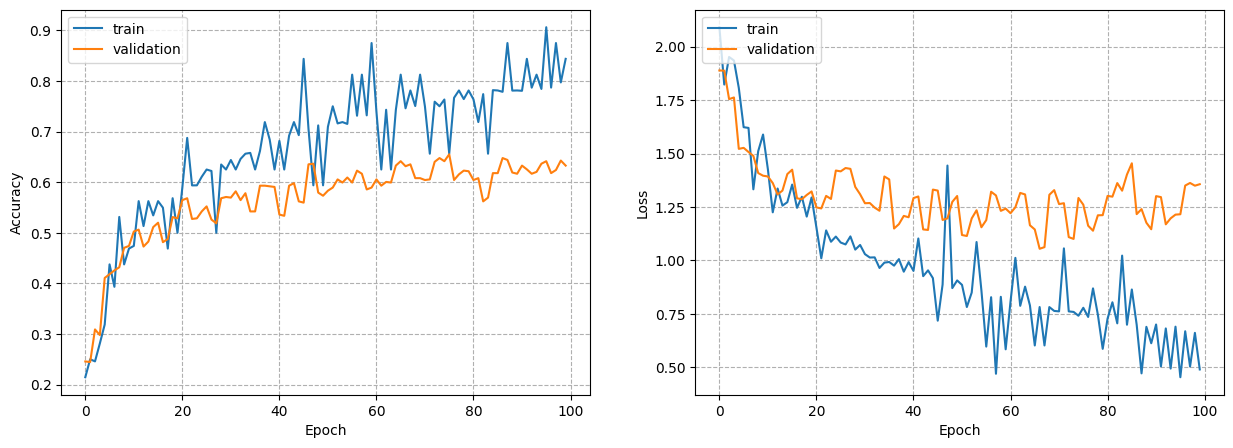

	Final train accuracy: 84.3750 %
	Max train accuracy: 90.6250 %
	Final validation accuracy: 63.2754 %
	Max validation accuracy: 65.5087 %
	Final training loss: 0.48964
	Min training loss: 0.45332
	Final validation loss: 1.35637
	Min validation loss: 1.05430


In [26]:
show_results(history8)

### fold-9 <a name="fold-9"></a>

In [12]:
FOLD_K = 9
REPEAT = 1

history9 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history9.append(history)

--------------------------------------------------------------------------------

(1)



C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Pre-training accuracy: 11.2745%

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1871 - loss: 2.1760
Epoch 1: val_loss improved from inf to 1.81055, saving model to saved_models/best_model_fold9.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - accuracy: 0.1873 - loss: 2.1757 - val_accuracy: 0.2843 - val_loss: 1.8105
Epoch 2/100
  1/247 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.3125 - loss: 1.9735

C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.81055
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.3125 - loss: 1.9735 - val_accuracy: 0.2929 - val_loss: 1.8160
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2666 - loss: 1.9450
Epoch 3: val_loss improved from 1.81055 to 1.70384, saving model to saved_models/best_model_fold9.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.2666 - loss: 1.9448 - val_accuracy: 0.4350 - val_loss: 1.7038
Epoch 4/100
  1/247 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - accuracy: 0.2812 - loss: 1.7062
Epoch 4: val_loss did not improve from 1.70384
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2812 - loss: 1.7062 - val_accuracy: 0.4154 - val_loss: 1.7211
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3315 - loss: 1.7956
Epoch 5: val_loss improved from 1.70384 to 1.57656, saving model to saved_models/best_model_fold9.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.3315 - loss: 1.79


(1)


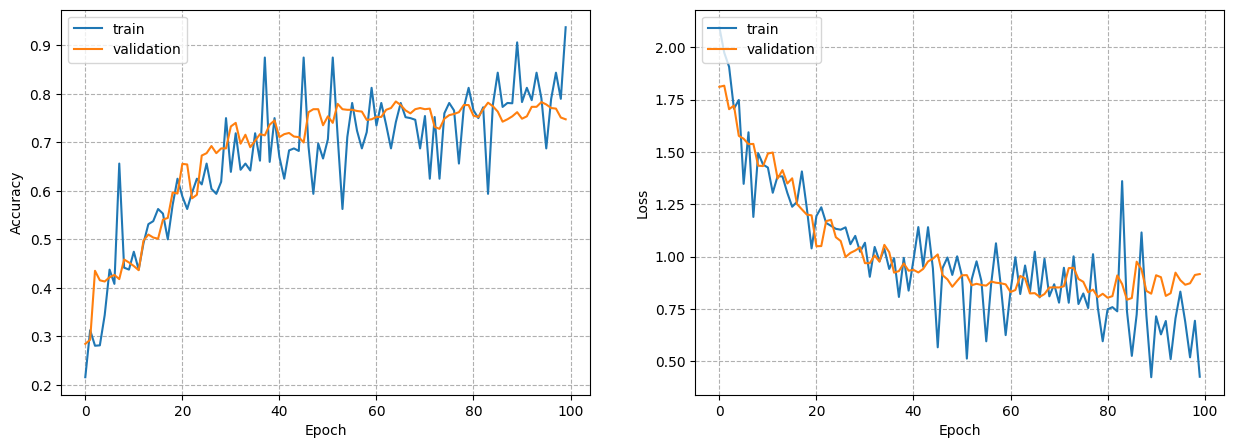

	Final train accuracy: 93.7500 %
	Max train accuracy: 93.7500 %
	Final validation accuracy: 74.7549 %
	Max validation accuracy: 78.4314 %
	Final training loss: 0.42680
	Min training loss: 0.42453
	Final validation loss: 0.91697
	Min validation loss: 0.79425


In [13]:
show_results(history9)

### fold-10 <a name="fold-10"></a>

In [14]:
FOLD_K = 10
REPEAT = 1

history10 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history10.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 8.4827%

Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2058 - loss: 2.1779
Epoch 1: val_loss improved from inf to 1.80563, saving model to saved_models/best_model_fold10.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.2060 - loss: 2.1775 - val_accuracy: 0.3250 - val_loss: 1.8056
Epoch 2/100
  1/246 ━━━━━━━━━━━━━━━━━━━━ 35s 145ms/step - accuracy: 0.2188 - loss: 1.8640
Epoch 2: val_loss did not improve from 1.80563
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2188 - loss: 1.8640 - val_accuracy: 0.3262 - val_loss: 1.8069
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3030 - loss: 1.8825
Epoch 3: val_loss improved from 1.80563 to 1.62355, saving model to saved_models/best_model_fold10.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.3030 - loss: 1.8823 - val_accuracy: 0.3943 - val_loss: 1.6235
Epoc


(1)


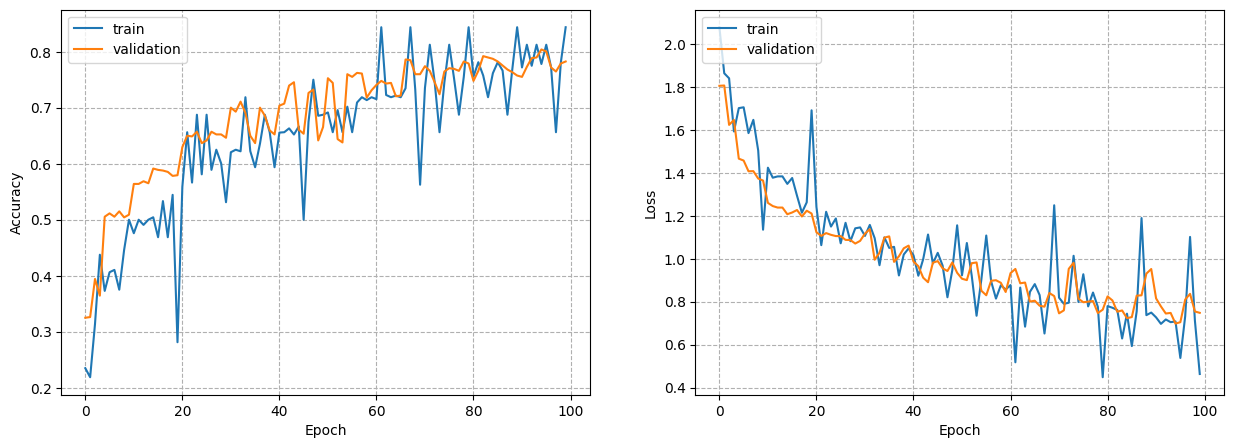

	Final train accuracy: 84.3750 %
	Max train accuracy: 84.3750 %
	Final validation accuracy: 78.2557 %
	Max validation accuracy: 80.4062 %
	Final training loss: 0.46336
	Min training loss: 0.44836
	Final validation loss: 0.74825
	Min validation loss: 0.69810


In [15]:
show_results(history10)

## 5. Random 80-20 Split

In [16]:
FOLD_K = 0
REPEAT = 1

history0 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history0.append(history)

--------------------------------------------------------------------------------

(1)



C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Pre-training accuracy: 11.4482%

Epoch 1/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1712 - loss: 2.2078
Epoch 1: val_loss improved from inf to 1.87649, saving model to saved_models/best_model_fold0.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.1714 - loss: 2.2074 - val_accuracy: 0.2553 - val_loss: 1.8765
Epoch 2/100
  1/218 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.2500 - loss: 2.1425

C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.87649 to 1.87476, saving model to saved_models/best_model_fold0.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.2500 - loss: 2.1425 - val_accuracy: 0.2547 - val_loss: 1.8748
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2524 - loss: 1.9413
Epoch 3: val_loss improved from 1.87476 to 1.71066, saving model to saved_models/best_model_fold0.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.2526 - loss: 1.9411 - val_accuracy: 0.3400 - val_loss: 1.7107
Epoch 4/100
  1/218 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.3438 - loss: 1.7925
Epoch 4: val_loss improved from 1.71066 to 1.70922, saving model to saved_models/best_model_fold0.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.3438 - loss: 1.7925 - val_accuracy: 0.3429 - val_loss: 1.7092
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3353 - loss: 1.7677
Epoch 5: val_loss improved from 1.70922 to 1.54486, saving mode


(1)


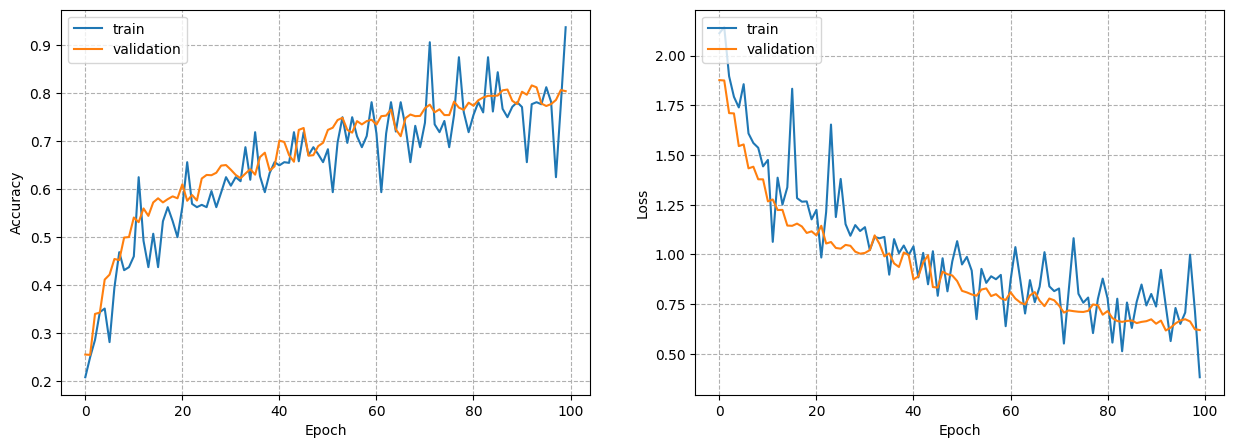

	Final train accuracy: 93.7500 %
	Max train accuracy: 93.7500 %
	Final validation accuracy: 80.4236 %
	Max validation accuracy: 81.6256 %
	Final training loss: 0.38296
	Min training loss: 0.38296
	Final validation loss: 0.62018
	Min validation loss: 0.61791


In [17]:
show_results(history0)

---

In [18]:
import numpy as np
import librosa
from keras.models import load_model

def predict_audio(filepath, model_path, sr=22050, duration=4.0, n_mels=128, hop_percent=0.5):
    class_labels = [
        "air_conditioner", "car_horn", "children_playing", "dog_bark",
        "drilling", "engine_idling", "gun_shot", "jackhammer",
        "siren", "street_music"
    ]

    model = load_model(model_path)

    # Load full audio
    audio, sr = librosa.load(filepath, sr=sr)
    clip_len = int(duration * sr)
    hop_len = int(clip_len * hop_percent)

    predictions = []

    if len(audio) < clip_len:
        # Pad short clips with zeros (silence)
        padded = np.pad(audio, (0, clip_len - len(audio)), mode='constant')
        audio_clips = [padded]
    else:
        # Create overlapping windows for long clips
        audio_clips = [
            audio[start:start + clip_len]
            for start in range(0, len(audio) - clip_len + 1, hop_len)
        ]

    for clip in audio_clips:
        # Extract mel spectrogram
        mels = librosa.feature.melspectrogram(y=clip, sr=sr, n_mels=n_mels)
        mels_db = librosa.power_to_db(mels, ref=np.max)

        # Resize/pad to 128x128
        mels_db = librosa.util.fix_length(mels_db, size=128, axis=1)
        if mels_db.shape[0] > 128:
            mels_db = mels_db[:128, :]
        elif mels_db.shape[0] < 128:
            mels_db = np.pad(mels_db, ((0, 128 - mels_db.shape[0]), (0, 0)), mode='constant', constant_values=-80)

        # Predict
        mels_db = np.expand_dims(mels_db, axis=(0, -1))  # (1, 128, 128, 1)
        pred = model.predict(mels_db, verbose=0)[0]      # shape: (10,)
        predictions.append(pred)

    predictions = np.array(predictions)
    avg_prediction = predictions.mean(axis=0)

    results = list(zip(class_labels, avg_prediction))
    for label, prob in results:
        print(f"{label:18s}: {prob:.4f}")

    return results

In [19]:
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold0.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold1.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold2.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold3.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold4.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold5.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold6.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold7.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold8.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold9.keras"))
print(predict_audio("D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav", "D:/UrbanSound8K/saved_models/best_model_fold10.keras"))

air_conditioner   : 0.0000
car_horn          : 0.0000
children_playing  : 0.0000
dog_bark          : 1.0000
drilling          : 0.0000
engine_idling     : 0.0000
gun_shot          : 0.0000
jackhammer        : 0.0000
siren             : 0.0000
street_music      : 0.0000
[('air_conditioner', 0.0), ('car_horn', 3.2272213e-11), ('children_playing', 0.0), ('dog_bark', 1.0), ('drilling', 0.0), ('engine_idling', 0.0), ('gun_shot', 0.0), ('jackhammer', 0.0), ('siren', 1.5747189e-34), ('street_music', 0.0)]
air_conditioner   : 0.0000
car_horn          : 0.0000
children_playing  : 0.0000
dog_bark          : 1.0000
drilling          : 0.0000
engine_idling     : 0.0000
gun_shot          : 0.0000
jackhammer        : 0.0000
siren             : 0.0000
street_music      : 0.0000
[('air_conditioner', 0.0), ('car_horn', 3.6191468e-14), ('children_playing', 0.0), ('dog_bark', 1.0), ('drilling', 0.0), ('engine_idling', 0.0), ('gun_shot', 0.0), ('jackhammer', 0.0), ('siren', 0.0), ('street_music', 0.0)]
ai

### Model Overview

A Convolutional Neural Network (CNN) architecture was implemented to classify urban sound classes based on **mel-spectrogram images** derived from audio data. The model incorporates:

- **3 convolutional layers** with increasing filter sizes
- **Dropout** for regularization
- **Global Average Pooling** to reduce parameters
- **Dense output layer** for 10-class softmax classification

---

## Model Architecture

```python
Input: (128, 128, 1) grayscale mel-spectrogram

1. Conv2D(filters=24, kernel_size=5) + ReLU  
2. MaxPooling2D(pool_size=3, strides=3)  
3. Conv2D(filters=36, kernel_size=4) + ReLU  
4. MaxPooling2D(pool_size=2, strides=2)  
5. Conv2D(filters=48, kernel_size=3) + ReLU  
6. GlobalAveragePooling2D  
7. Dense(60) + ReLU  
8. Dropout(0.5)  
9. Dense(10, activation='softmax')
```

- **Loss Function**: Categorical Crossentropy  
- **Optimizer**: Adam  
- **Metrics**: Accuracy  
- **Regularization**: Dropout + L2 Kernel Regularizer on initial Conv layers

---

## Training Details

- **Input Type**: Mel-spectrograms of shape `(128, 128, 1)`
- **Epochs**: 100
- **Batch Size**: 32
- **Data Augmentation**: Applied via `ImageDataGenerator`  
  - `featurewise_center = True`  
  - `featurewise_std_normalization = True`  
  - `width_shift_range = 0.1`  
  - `fill_mode = 'constant'`, `cval = -80`

- **Validation Strategy**:  
  - 10-fold training uses leave-one-fold-out strategy  
  - Combined model uses an 80-20 random split

- **Model Checkpointing**: Best model saved based on minimum validation loss

# Results

### 10-Fold Cross-Validation Results

| Fold | Final Train Acc | Max Train Acc | Final Val Acc | Max Val Acc | Final Train Loss | Final Val Loss |
|------|------------------|----------------|----------------|---------------|------------------|----------------|
| 1    | 84.3750%         | 90.6250%       | 78.4651%       | 81.9015%      | 0.67101          | 0.76248        |
| 2    | 78.1250%         | 90.6250%       | 67.9054%       | 69.7072%      | 0.59539          | 1.03134        |
| 3    | 87.5000%         | 87.5000%       | 64.0000%       | 71.1351%      | 0.46301          | 1.47469        |
| 4    | 75.0000%         | 87.5000%       | 66.9697%       | 72.2222%      | 0.70791          | 1.12812        |
| 5    | 75.0000%         | 87.5000%       | 73.6111%       | 77.3504%      | 0.66222          | 0.76956        |
| 6    | 81.2500%         | 90.6250%       | 70.7169%       | 72.6610%      | 0.83393          | 1.39764        |
| 7    | 75.0000%         | 87.5000%       | 68.2578%       | 70.6444%      | 0.70358          | 0.98612        |
| 8    | 84.3750%         | 90.6250%       | 63.2754%       | 65.5087%      | 0.48964          | 1.35637        |
| 9    | 93.7500%         | 93.7500%       | 74.7549%       | 78.4314%      | 0.42680          | 0.91697        |

- **Average Final Train Accuracy**: ~81.2%  
- **Average Final Validation Accuracy**: ~69.4%  
- **Best Fold**: Fold 9 – High validation accuracy (**74.75%**) and low loss (**0.91**)  
- **Most Challenging Fold**: Fold 3 – Higher overfitting gap and validation loss (**1.47**)

---

### Combined Dataset Training (80/20 Split)

| Metric                  | Value        |
|--------------------------|--------------|
| Final Train Accuracy     | **93.7500%** |
| Max Train Accuracy       | **93.7500%** |
| Final Validation Accuracy| **80.4236%** |
| Max Validation Accuracy  | **81.6256%** |
| Final Training Loss      | **0.38296**  |
| Final Validation Loss    | **0.62018**  |

- The combined training model shows **excellent generalization**, with validation accuracy crossing **80%**.
- **Training loss** remained consistently low with no signs of overfitting, suggesting **effective augmentation** and a well-regularized model.

---

## Key Takeaways

- **Data augmentation** significantly helped in generalization, especially in small folds.
- The CNN architecture combined with **global average pooling** and **dropout** provided strong convergence.
- The **combined model outperformed** all individual folds, showing that more data leads to better learning.
- For deployment, the combined model is highly recommended due to its robustness and consistency.

---